# Evaluation
This notebook presents evalulation results of final models on different test sets

In [21]:
import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from itertools import combinations, permutations

import cmbnet.utils.utils_plotting as utils_plotting

In [22]:
eval_dir = "../../data-misc/evaluations"
l1_dirs = ['Scratch-Pretrained-FineTuned', 'TL-Pretrained-FineTuned']
l2_dirs = ['predict_cmb_valid', 'predict_cmb_dou', 'predict_cmb_crb']
l3_dirs = ['valloss', 'F1macro']

classification_fname = "classification_metrics.csv"
detection_metrics_fname = "detection_metrics.csv"
segmentation_metrics_fname = "segmentation_metrics.csv"

study_results_det_fname = 'study_results_detection.pkl'
study_results_seg_fname = 'study_results_segmentation.pkl'

In [23]:
classification_data = []
detection_data = []
segmentation_data = []

# Loop through models, criteria, and then datasets
for l1 in l1_dirs:
    for l3 in l3_dirs:
        for l2 in l2_dirs:
            dataset = l2.split('_')[-1]  # Extract the dataset name from l2
            base_path = os.path.join(eval_dir, l1, l2, l3)
            class_path = os.path.join(base_path, classification_fname)
            detect_path = os.path.join(base_path, detection_metrics_fname)
            seg_path = os.path.join(base_path, segmentation_metrics_fname)

            # Load classification metrics if available
            if os.path.exists(class_path):
                df_class = pd.read_csv(class_path)
                df_class['Model'] = l1
                df_class['Criteria'] = l3
                df_class['Dataset'] = dataset

                classification_data.append(df_class)

            # Load detection metrics if available
            if os.path.exists(detect_path):
                df_detect = pd.read_csv(detect_path)
                df_detect['Model'] = l1
                df_detect['Criteria'] = l3
                df_detect['Dataset'] = dataset

                detection_data.append(df_detect)

            # Load segmentation metrics if available
            if os.path.exists(seg_path):
                df_seg = pd.read_csv(seg_path)
                df_seg['Model'] = l1
                df_seg['Criteria'] = l3
                df_seg['Dataset'] = dataset

                segmentation_data.append(df_seg)

# Concatenate data into separate dataframes for each metric type
df_classification = pd.concat(classification_data, ignore_index=True)
df_detection = pd.concat(detection_data, ignore_index=True)
df_segmentation = pd.concat(segmentation_data, ignore_index=True)

# move columns Model, Criteria and Dataste in front
cols = df_classification.columns.tolist()
cols = cols[-3:] + cols[:-3]
df_classification = df_classification[cols]

cols = df_detection.columns.tolist()
cols = cols[-3:] + cols[:-3]
df_detection = df_detection[cols]

cols = df_segmentation.columns.tolist()
cols = cols[-3:] + cols[:-3]
df_segmentation = df_segmentation[cols]

In [24]:
# Dictionaries to store detailed study data
detection_details = {}
segmentation_details = {}

for l1 in l1_dirs:
    for l2 in l2_dirs:
        dataset = l2.split('_')[-1]  # Extract dataset name from l2
        for l3 in l3_dirs:
            base_path = os.path.join(eval_dir, l1, l2, l3)
            # File paths
            class_path = os.path.join(base_path, classification_fname)
            detect_path = os.path.join(base_path, detection_metrics_fname)
            seg_path = os.path.join(base_path, segmentation_metrics_fname)
            detect_study_path = os.path.join(base_path, study_results_det_fname)
            seg_study_path = os.path.join(base_path, study_results_seg_fname)
            
            # Load study result details if available
            if os.path.exists(detect_study_path):
                with open(detect_study_path, 'rb') as file:
                    detection_details[(l1, dataset, l3)] = pickle.load(file)
            if os.path.exists(seg_study_path):
                with open(seg_study_path, 'rb') as file:
                    segmentation_details[(l1, dataset, l3)] = pickle.load(file)

## Detection results

In [25]:
# TODO: select which to show

dataset = ["dou"]
model = ["Scratch-Pretrained-FineTuned"]
criteria = ["F1macro", "valloss"]
typemetric = "Micro"
df = df_detection


selected = df[(df['Dataset'].isin(dataset)) & (df['Model'].isin(model)) & (df['Criteria'].isin(criteria))]
selected = selected[selected['Metric'].str.contains(typemetric)]
selected

,Model,Criteria,Dataset,Metric,Mean,Std.
0,Scratch-Pretrained-FineTuned,valloss,dou,Micro - Precision,0.822581,NaN
1,Scratch-Pretrained-FineTuned,valloss,dou,Micro - Recall,0.689189,NaN
2,Scratch-Pretrained-FineTuned,valloss,dou,Micro - F1,0.750000,NaN
3,Scratch-Pretrained-FineTuned,valloss,dou,Micro - FPavg,0.550000,NaN
4,Scratch-Pretrained-FineTuned,valloss,dou,Micro - FPcmb,0.148649,NaN
20,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - Precision,0.886364,NaN
21,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - Recall,0.527027,NaN
22,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - F1,0.661017,NaN
23,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - FPavg,0.250000,NaN
24,Scratch-Pretrained-FineTuned,F1macro,dou,Micro - FPcmb,0.067568,NaN


In [26]:
metrics = ['Precision', 'Recall', 'F1']
detection_details_comb = detection_details[('Scratch-Pretrained-FineTuned',
  'dou',
  'valloss')]
pd.DataFrame(
            {
                "seriesUID": [s['seriesUID'] for s in detection_details_comb],
                **{
                    metric: [m[metric] for m in detection_details_comb]
                    for metric in metrics
                },
                }
        )

,seriesUID,Precision,Recall,F1
0,DOU-15-CMB-13,0.642857,0.692308,0.666667
1,DOU-04-CMB-1,NaN,0.000000,NaN
2,DOU-14-CMB-3,1.000000,1.000000,1.000000
3,DOU-19-CMB-1,1.000000,1.000000,1.000000
4,DOU-05-CMB-1,0.333333,1.000000,0.500000
5,DOU-08-CMB-1,1.000000,1.000000,1.000000
6,DOU-10-CMB-8,1.000000,0.750000,0.857143
7,DOU-02-CMB-1,1.000000,1.000000,1.000000
8,DOU-07-CMB-1,NaN,0.000000,NaN
9,DOU-06-CMB-1,1.000000,1.000000,1.000000


/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

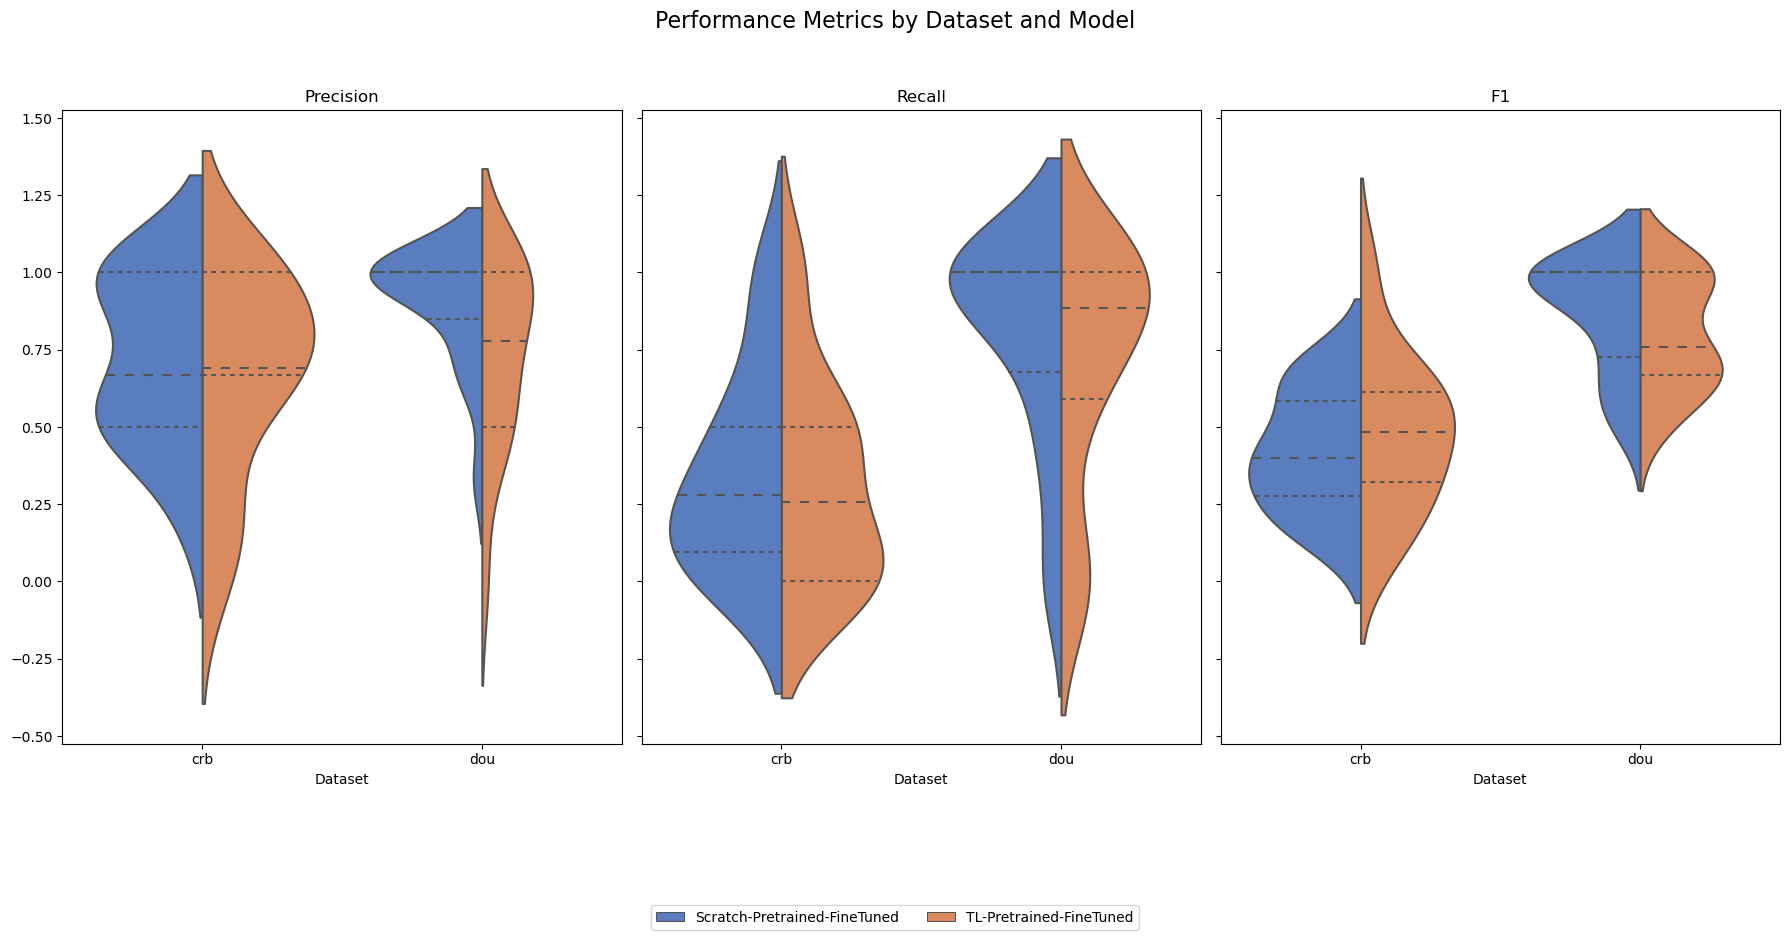

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Definitions
datasets = ["crb", "dou"]
models = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
criteria = ["valloss"]
metrics = ["Precision", "Recall", "F1"]

# Setup figure and axes
fig, axs = plt.subplots(1, len(metrics), figsize=(18, 9), sharey=True)  # One row for each metric across models
fig.suptitle("Performance Metrics by Dataset and Model", fontsize=16)

# Iterate over metrics to create a plot for each
for j, metric in enumerate(metrics):
    data_comb = pd.DataFrame()
    for model in models:
        for dataset in datasets:
            # Check if the data combination exists in the details dictionary
            if (model, dataset, criteria[0]) in detection_details:
                detection_details_comb = detection_details[(model, dataset, criteria[0])]
                # Build the DataFrame for the current model and dataset
                model_data = pd.DataFrame({
                    "Value": [s[metric] for s in detection_details_comb],
                    "Dataset": [dataset] * len(detection_details_comb),
                    "Model": [model] * len(detection_details_comb)
                })
                # Concatenate to the combined DataFrame
                data_comb = pd.concat([data_comb, model_data], ignore_index=True)

    # Plot if data_comb is not empty
    if not data_comb.empty:
        sns.violinplot(x="Dataset", y="Value", hue="Model", data=data_comb, ax=axs[j], palette="muted", split=True, inner="quartile")
        axs[j].set_title(f'{metric.capitalize()}')
        axs[j].set_xlabel('Dataset')
        axs[j].set_ylabel("")
        axs[j].tick_params(axis="x", labelsize=10)
        axs[j].tick_params(axis="y", labelsize=10)

        # Remove the legend from all except the last plot
        axs[j].get_legend().remove()

# Add a single unified legend for the whole figure
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(models), bbox_to_anchor=(0.5, -0.05))

# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig("../../data-misc/img/final_scores_dataset_model.png")
plt.show()